In [1]:
# data loading
import sqlalchemy as sql
import pandas as pd
import numpy as np
# fitting
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import LearningRateScheduler
# check
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [47]:
LC = "LCT-19-580"
url = "sqlite:///../database/demo.db"

In [48]:
# import data
engine = sql.create_engine(url, echo=False)

opt = pd.read_sql(f'SELECT ID, Point as point, Voltage/2 as Vop, "LCM_Y%" as "LC%" FROM opt WHERE LC == "{LC}"', engine)
cell_gap = pd.read_sql(f'SELECT ID, Point as point, "cell gap" FROM axo WHERE LC == "{LC}"', engine)



In [49]:
opt = pd.merge(opt, cell_gap, how="left", on=["ID", "point"])
opt["T%"] = opt.groupby(by=["ID", "point"])["LC%"].apply(lambda x: 100*x / float(x.max()))
opt

,ID,point,Vop,LC%,cell gap,T%
0,T108C001NM21,1,0.0,0.000056,2.268366,0.008135
1,T108C001NM21,1,0.2,0.000103,2.268366,0.014962
2,T108C001NM21,1,0.4,0.000062,2.268366,0.009006
3,T108C001NM21,1,0.6,0.000195,2.268366,0.028326
4,T108C001NM21,1,0.8,0.000523,2.268366,0.075973
...,...,...,...,...,...,...
3055,T108C001NM2K,6,9.2,0.797783,2.519869,98.808158
3056,T108C001NM2K,6,9.4,0.794256,2.519869,98.371327
3057,T108C001NM2K,6,9.6,0.793753,2.519869,98.309029
3058,T108C001NM2K,6,9.8,0.791212,2.519869,97.994318


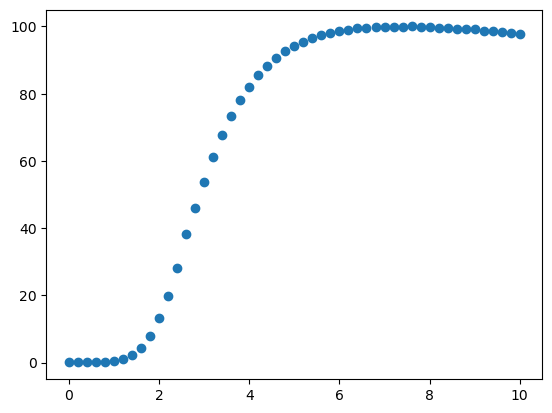

In [26]:
# test draw
tmp_df = opt[(opt["ID"] == "T108C001NM2Q") & (opt["point"] == 1)][["Vop", "T%"]]
plt.scatter(tmp_df["Vop"], tmp_df["T%"])
plt.show()

In [50]:
# data split
df = opt[["Vop", "cell gap", "T%"]].to_numpy()
training_set, test_set = train_test_split(
    df,
    test_size = 0.2,
#     random_state = 42
)
X_train = training_set[:,:-1]
y_train = training_set[:,-1]
X_test = test_set[:,:-1]
y_test = test_set[:,-1]

In [51]:
num_features = X_train.shape[-1]

In [52]:
inputs = Input(shape=(num_features,), name="input_layer")
x = preprocessing.Normalization()(inputs)
x = Dense(3, use_bias=True, activation='sigmoid', name='dense1')(x)
x = BatchNormalization()(x)
x = Dense(6, use_bias=True, activation='relu', name='dense2')(x)
x = BatchNormalization()(x)
x = Dense(3, use_bias=True, activation='relu', name='dense3')(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation='linear', name="output")(x)

model = Model(inputs, outputs, name='linear_regression')

model.summary()

Model: "linear_regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
normalization_3 (Normalizati (None, 2)                 5         
_________________________________________________________________
dense1 (Dense)               (None, 3)                 9         
_________________________________________________________________
batch_normalization_9 (Batch (None, 3)                 12        
_________________________________________________________________
dense2 (Dense)               (None, 6)                 24        
_________________________________________________________________
batch_normalization_10 (Batc (None, 6)                 24        
_________________________________________________________________
dense3 (Dense)               (None, 3)           

In [53]:
def step_decay(epoch):
    initial_lrate = 0.001 # 初始化學習率
    drop = 0.8 # 每次遞減率
    epochs_drop = 20 # 每 100 個 epochs 降低一次學習率
    lrate = initial_lrate * tf.math.pow(drop, tf.math.floor((1+epoch)/epochs_drop))
    return lrate
# 建立 LearningRateScheduler
lr_schedule = LearningRateScheduler(step_decay, verbose=1)

In [54]:
model.compile(loss="MSE", optimizer=SGD(learning_rate=1e-4))
# batch_size = 32
batch_size = X_train.shape[0]
history = model.fit(
    epochs=2000,
    batch_size=batch_size,
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    callbacks=[lr_schedule]
)

Epoch 1/2000

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
1/1 [==============================] - 1s 658ms/step - loss: 6103.5869 - val_loss: 6430.1699
Epoch 2/2000

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
1/1 [==============================] - 0s 27ms/step - loss: 6055.2051 - val_loss: 6396.8408
Epoch 3/2000

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
1/1 [==============================] - 0s 31ms/step - loss: 6010.9590 - val_loss: 6360.2192
Epoch 4/2000

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
1/1 [==============================] - 0s 28ms/step - loss: 5959.5278 - val_loss: 6321.3677
Epoch 5/2000

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
1/1 [==============================] - 0s

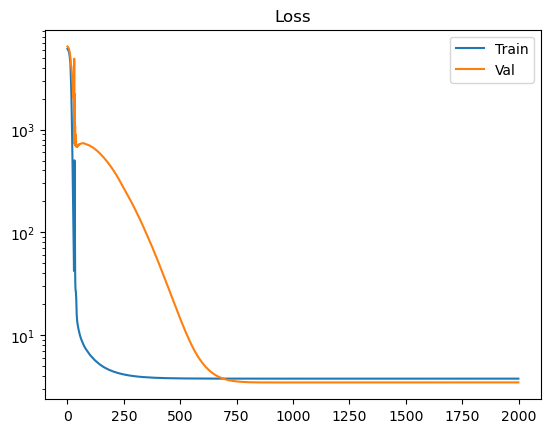

In [55]:
training_loss, val_loss = history.history['loss'], history.history['val_loss']

plt.title('Loss')
plt.plot(training_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend()
plt.yscale('log')
plt.show()


In [139]:
y_pred = model.predict(df[:,:-1])
y_true = df[:,-1]
r2_score(y_true, y_pred)

0.999391606330861

In [140]:
query_gap = 2.5
x_query = np.linspace(0, 10, 100)
x_query = [[v, query_gap] for v in x_query]
x_query = np.array(x_query)

In [141]:
x_query.shape

(100, 2)

In [142]:
y_query = model.predict(x_query)

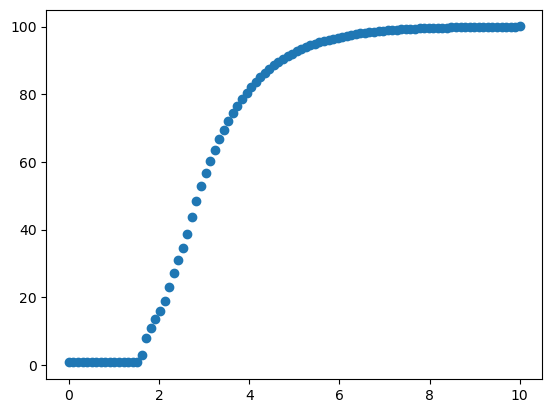

In [143]:
plt.scatter(x_query[:,0], y_query)
plt.show()

In [46]:
model.save(f'{LC}-VT.h5')

In [60]:
import os

In [138]:
from tensorflow.keras.models import load_model
path = '../notebooks/'+ f'{LC}-VT.h5'
model = load_model(path)

In [71]:
result_df = pd.DataFrame(x_query, columns=["Vop", "cell gap"])
result_df["T%"] = y_query

In [76]:
import time
print(time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime()))

2021-07-22-12-54-53


In [132]:
params = {
    "LC": "LCT-19-580, MOX-1",
    "cell_gap": "2.5, 2.1",
    "V_max": "10.0, 10.0",
    "V_min": "2.0, 2.0"
}

In [136]:
new_params = {}
for k, v in params.items():
    new_params[k] = v.split(",")

In [137]:
new_params

{'LC': ['LCT-19-580', ' MOX-1'],
 'cell_gap': ['2.5', ' 2.1'],
 'V_max': ['10.0', ' 10.0'],
 'V_min': ['2.0', ' 2.0']}